In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.01,
    "momentum" : 0.99,
    "weight_decay" : 3e-5,
    "epcohs":30,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-AllClass"
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]

In [3]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [4]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
f_alpha = (1-b)/(1-np.power(b,train_class_counts))
print(f_alpha)

[0.00143064 0.00320357 0.00319653 0.00323937 0.0038239  0.00244738
 0.00244738 0.003468   0.00375    0.00556448 0.01478441 0.04809698
 1.         0.00365007 0.01689033 0.00825881 0.00380244 0.00985004
 0.02090204 0.0268058  0.00482751 0.02374777 0.02132692 0.03274452
 0.01637033 0.00838066]


In [5]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [6]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [7]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [9]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
# optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
optimizer = torch.optim.SGD(
    model.parameters(),
    momentum=args["momentum"],
    lr=args["lr"],
    nesterov=True,
    weight_decay=args["weight_decay"]
)
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : 0.49470812946557996 - CE loss : 0.49935054004192353 - dice loss : -0.004642413684632629

train avg metrics for epoch 0 :
avg dice : 0.0011680501531534304 - avg precision : 0.0019787115904910026 - avg recall : 0.001583705996581557
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 0.194431059807539 - CE loss : 0.20216943919658661 - dice loss : -0.00773838113527745

valid avg metrics for epoch 0 :
avg dice : 4.2089307896158585e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1)
total loss : 0.17177354753017426 - CE loss : 0.18156018391251563 - dice loss : -0.009786636587232351

train avg metrics for epoch 1 :
avg dice : 0.000642915517536465 - avg precision : 0.005019373893737793 - avg recall : 0.00034345366060733795
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 0.17414965257048606 - CE loss : 0.18771227374672889 - dice loss : -0.01356262071058154

valid avg metrics for epoch 1 :
avg dice : 0.0028118512038596954 - avg precision : 0.00474337100982666 - avg recall : 0.0019981829822063447
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2)
total loss : 0.1423282476514578 - CE loss : 0.15849845811724664 - dice loss : -0.016170210037380457

train avg metrics for epoch 2 :
avg dice : 0.007402408974456582 - avg precision : 0.010674898624420165 - avg recall : 0.007943671814282426
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 0.14733793213963509 - CE loss : 0.16624548211693763 - dice loss : -0.018907549418509008

valid avg metrics for epoch 2 :
avg dice : 0.008524396121917738 - avg precision : 0.008914548456668853 - avg recall : 0.009778284281492234
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : 0.1278982362896204 - CE loss : 0.14747112430632114 - dice loss : -0.019572888519614935

train avg metrics for epoch 3 :
avg dice : 0.0058473353837402075 - avg precision : 0.010449859499931335 - avg recall : 0.010323174241930246
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.1373215105384588 - CE loss : 0.15824299529194832 - dice loss : -0.02092148382216692

valid avg metrics for epoch 3 :
avg dice : 0.005073990226210566 - avg precision : 0.003394571542739868 - avg recall : 0.010042266845703125
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.12009097695350647 - CE loss : 0.14141496241092683 - dice loss : -0.021323985047638418

train avg metrics for epoch 4 :
avg dice : 0.00509482860609666 - avg precision : 0.003310747742652893 - avg recall : 0.011048704385757446
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.13034641668200492 - CE loss : 0.15259903371334077 - dice loss : -0.02225261749699712

valid avg metrics for epoch 4 :
avg dice : 0.005198282003821345 - avg precision : 0.0034061715006828306 - avg recall : 0.010969995260238648
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 0.1158336103707552 - CE loss : 0.13830645203590394 - dice loss : -0.02247284147888422

train avg metrics for epoch 5 :
avg dice : 0.005308757424799339 - avg precision : 0.0033608511090278625 - avg recall : 0.012627487182617187
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.1268304418772459 - CE loss : 0.15018561705946923 - dice loss : -0.023355175741016865

valid avg metrics for epoch 5 :
avg dice : 0.0064914053682698925 - avg precision : 0.0040993249416351315 - avg recall : 0.015586743354797363
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.11219427183270454 - CE loss : 0.1354354889690876 - dice loss : -0.02324121681973338

train avg metrics for epoch 6 :
avg dice : 0.00564429462000576 - avg precision : 0.0035034218430519105 - avg recall : 0.014512758255004882
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.12519242353737353 - CE loss : 0.14923330768942833 - dice loss : -0.02404088405892253

valid avg metrics for epoch 6 :
avg dice : 0.006163941026152583 - avg precision : 0.0038494604825973513 - avg recall : 0.01545807957649231
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 0.10813840843737126 - CE loss : 0.1326783787459135 - dice loss : -0.024539969693869353

train avg metrics for epoch 7 :
avg dice : 0.005552358031717712 - avg precision : 0.003382572829723358 - avg recall : 0.015486021041870118
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.1238538209348917 - CE loss : 0.14832671359181404 - dice loss : -0.024472893215715885

valid avg metrics for epoch 7 :
avg dice : 0.007034613490523311 - avg precision : 0.0043529334664344785 - avg recall : 0.018322300910949708
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8)
total loss : 0.1061448959261179 - CE loss : 0.13100455999374389 - dice loss : -0.024859664048999548

train avg metrics for epoch 8 :
avg dice : 0.005658811888868888 - avg precision : 0.02480429083108902 - avg recall : 0.016004414668423124
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : 0.12174015082418918 - CE loss : 0.14670108444988728 - dice loss : -0.024960933439433574

valid avg metrics for epoch 8 :
avg dice : 0.006294848323286981 - avg precision : 0.00388008326292038 - avg recall : 0.016668416261672973
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 0.10360974457114935 - CE loss : 0.1291198919713497 - dice loss : -0.02551014706492424

train avg metrics for epoch 9 :
avg dice : 0.005696936566826888 - avg precision : 0.01815506011247635 - avg recall : 0.01579014625400305
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.12101842537522316 - CE loss : 0.14645758867263795 - dice loss : -0.025439163018018008

valid avg metrics for epoch 9 :
avg dice : 0.0069176333960578595 - avg precision : 0.017676246464252473 - avg recall : 0.018732139300554992
1 => dice : 7.779618827396736e-14 p : 0.0 , r : 0.0
2 => dice : 0.006003364454954863 p : 0.3401898741722107 , r : 0.003028403501957655
3 => dice : 8.138749277384477e-14 p : 0.0 , r : 0.0
4 => dice : 1.142556779439377e-13 p : 0.0 , r : 0.0
5 => dice : 6.149040423977098e-14 p : 0.0 , r : 0.0
6 => dice : 0.1669374704360962 p : 0.1017162874341011 , r : 0.4652750790119171
7 => dice : 6.754702862581813e-14 p : 0.0 , r : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10)
total loss : 0.10159774407744408 - CE loss : 0.1276811070740223 - dice loss : -0.026083362959325312

train avg metrics for epoch 10 :
avg dice : 0.0064130818103225636 - avg precision : 0.02028481662273407 - avg recall : 0.01764673352241516
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : 0.11936314515769482 - CE loss : 0.1452765867114067 - dice loss : -0.025913441460579632

valid avg metrics for epoch 10 :
avg dice : 0.008239784259764925 - avg precision : 0.019485344886779787 - avg recall : 0.0230649530608207
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : 0.09982988722622395 - CE loss : 0.12651501379907132 - dice loss : -0.026685126274824143

train avg metrics for epoch 11 :
avg dice : 0.008027350306955481 - avg precision : 0.017480192482471468 - avg recall : 0.01952656552195549
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : 0.1202692598104477 - CE loss : 0.1458125587552786 - dice loss : -0.025543299224227666

valid avg metrics for epoch 11 :
avg dice : 0.008545484543262498 - avg precision : 0.01773709088563919 - avg recall : 0.01629540219902992
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : 0.09933399021625519 - CE loss : 0.12575922422111036 - dice loss : -0.02642523415386677

train avg metrics for epoch 12 :
avg dice : 0.013907741308656529 - avg precision : 0.015971205234527587 - avg recall : 0.0244869726896286
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : 0.11687931828200818 - CE loss : 0.14303918965160847 - dice loss : -0.02615987081080675

valid avg metrics for epoch 12 :
avg dice : 0.013469439149318705 - avg precision : 0.01667471319437027 - avg recall : 0.022948208153247832
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13)
total loss : 0.09734663266688585 - CE loss : 0.12446639239788056 - dice loss : -0.027119759768247605

train avg metrics for epoch 13 :
avg dice : 0.014201475978341847 - avg precision : 0.014859276711940766 - avg recall : 0.02405315339565277
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : 0.11899399198591709 - CE loss : 0.14576357938349246 - dice loss : -0.026769586838781834

valid avg metrics for epoch 13 :
avg dice : 0.015122660398899089 - avg precision : 0.012088536620140075 - avg recall : 0.02877969741821289
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14)
total loss : 0.09625374242663383 - CE loss : 0.12366965278983116 - dice loss : -0.02741591038182378

train avg metrics for epoch 14 :
avg dice : 0.017502888441529668 - avg precision : 0.014831752479076386 - avg recall : 0.029206295013427735
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : 0.11880507208406925 - CE loss : 0.1456743735820055 - dice loss : -0.026869301777333023

valid avg metrics for epoch 14 :
avg dice : 0.015316513777194986 - avg precision : 0.01095321387052536 - avg recall : 0.029745289087295533
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15)
total loss : 0.09474317461252213 - CE loss : 0.12251469366252422 - dice loss : -0.027771519273519518

train avg metrics for epoch 15 :
avg dice : 0.017690650225129872 - avg precision : 0.013164060711860657 - avg recall : 0.03141161918640137
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : 0.11567257307469844 - CE loss : 0.1425801258534193 - dice loss : -0.02690755221992731

valid avg metrics for epoch 15 :
avg dice : 0.01743311643642045 - avg precision : 0.012816316485404967 - avg recall : 0.030575220584869386
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : 0.09412270501255988 - CE loss : 0.12193061031401158 - dice loss : -0.02780790511518717

train avg metrics for epoch 16 :
avg dice : 0.0195361512903841 - avg precision : 0.013845803737640381 - avg recall : 0.03592948079109192
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : 0.1170787662267685 - CE loss : 0.14430465064942838 - dice loss : -0.02722588451579213

valid avg metrics for epoch 16 :
avg dice : 0.01771054804366685 - avg precision : 0.012255116403102874 - avg recall : 0.032398545742034913
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : 0.09348242498934269 - CE loss : 0.1216735777258873 - dice loss : -0.028191153071820737

train avg metrics for epoch 17 :
avg dice : 0.019268746376481842 - avg precision : 0.013104991316795348 - avg recall : 0.037421267032623294
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : 0.11935232914984226 - CE loss : 0.14638619795441626 - dice loss : -0.0270338692702353

valid avg metrics for epoch 17 :
avg dice : 0.018252501488147745 - avg precision : 0.012404995858669282 - avg recall : 0.0345999276638031
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : 0.09208220034837723 - CE loss : 0.12053320944309234 - dice loss : -0.028451009225100278

train avg metrics for epoch 18 :
avg dice : 0.019566402435746935 - avg precision : 0.01294794499874115 - avg recall : 0.040034571886062624
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : 0.11612156890332699 - CE loss : 0.14348695576190948 - dice loss : -0.027365386858582495

valid avg metrics for epoch 18 :
avg dice : 0.016076851487575542 - avg precision : 0.010596614480018616 - avg recall : 0.0341401469707489
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19)
total loss : 0.09092417500913143 - CE loss : 0.11991452299058437 - dice loss : -0.02899034809321165

train avg metrics for epoch 19 :
avg dice : 0.019470915794816832 - avg precision : 0.012764214873313903 - avg recall : 0.0412907874584198
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : 0.11820159368216991 - CE loss : 0.14588803984224796 - dice loss : -0.027686446625739335

valid avg metrics for epoch 19 :
avg dice : 0.017047970891414653 - avg precision : 0.011131471991539 - avg recall : 0.03680215120315552
1 => dice : 7.779618827396736e-14 p : 0.0 , r : 0.0
2 => dice : 0.23567193746566772 p : 0.1499149650335312 , r : 0.5506834983825684
3 => dice : 8.138749277384477e-14 p : 0.0 , r : 0.0
4 => dice : 1.142556779439377e-13 p : 0.0 , r : 0.0
5 => dice : 6.149040423977098e-14 p : 0.0 , r : 0.0
6 => dice : 0.19052733480930328 p : 0.12837183475494385 , r : 0.3693702816963196
7 => dice : 6.754702862581813e-14 p : 0.0 , r : 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : 0.0902404984086752 - CE loss : 0.11929086074233056 - dice loss : -0.029050362687557937

train avg metrics for epoch 20 :
avg dice : 0.019267312288728567 - avg precision : 0.01263634979724884 - avg recall : 0.04128958225250244
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : 0.11699408888816834 - CE loss : 0.14486082568764685 - dice loss : -0.02786673782393336

valid avg metrics for epoch 20 :
avg dice : 0.016380723715244305 - avg precision : 0.010862910449504852 - avg recall : 0.035527400970458985
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : 0.08926719289273023 - CE loss : 0.11849705047905446 - dice loss : -0.029229857455939055

train avg metrics for epoch 21 :
avg dice : 0.01841838121458609 - avg precision : 0.012077740430831908 - avg recall : 0.041444302797317506
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : 0.11440390981733799 - CE loss : 0.14237337782979012 - dice loss : -0.027969467733055354

valid avg metrics for epoch 21 :
avg dice : 0.015777969956813822 - avg precision : 0.010426869690418243 - avg recall : 0.03637514293193817
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22)
total loss : 0.08833737403154374 - CE loss : 0.11790334597229958 - dice loss : -0.029565971679985523

train avg metrics for epoch 22 :
avg dice : 0.019037095308748378 - avg precision : 0.012453011870384216 - avg recall : 0.04317005634307861
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : 0.12038710340857506 - CE loss : 0.148405122384429 - dice loss : -0.028018019441515208

valid avg metrics for epoch 22 :
avg dice : 0.017395376563488017 - avg precision : 0.011663798391819 - avg recall : 0.03672457098960877
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23)
total loss : 0.08725858282297849 - CE loss : 0.1170910994708538 - dice loss : -0.029832516517490148

train avg metrics for epoch 23 :
avg dice : 0.01910019278570725 - avg precision : 0.012531211376190185 - avg recall : 0.043058404922485354
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : 0.12039067707955838 - CE loss : 0.14871463365852833 - dice loss : -0.028323956206440924

valid avg metrics for epoch 23 :
avg dice : 0.018931591511188516 - avg precision : 0.012753732204437256 - avg recall : 0.03991795182228088
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : 0.08671758908778429 - CE loss : 0.11680332824587822 - dice loss : -0.03008573906496167

train avg metrics for epoch 24 :
avg dice : 0.0186535769705446 - avg precision : 0.012255841493606567 - avg recall : 0.04297299146652222
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : 0.11711208708584309 - CE loss : 0.1452578242868185 - dice loss : -0.02814573599025607

valid avg metrics for epoch 24 :
avg dice : 0.01882033944171525 - avg precision : 0.012664197683334351 - avg recall : 0.039229371547698975
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : 0.08625953186303377 - CE loss : 0.11654907815158368 - dice loss : -0.030289546474814414

train avg metrics for epoch 25 :
avg dice : 0.018561337590661815 - avg precision : 0.012250069975852967 - avg recall : 0.04291023254394531
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : 0.11730827614665032 - CE loss : 0.14581363014876841 - dice loss : -0.028505354095250367

valid avg metrics for epoch 25 :
avg dice : 0.01744500517886735 - avg precision : 0.01159686267375946 - avg recall : 0.03904886960983276
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26)
total loss : 0.08884063951671123 - CE loss : 0.11873353183269501 - dice loss : -0.029892892464995383

train avg metrics for epoch 26 :
avg dice : 0.019273288846459867 - avg precision : 0.01272636353969574 - avg recall : 0.043114811182022095
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : 0.11327606067061424 - CE loss : 0.14169820100069047 - dice loss : -0.028422140795737506

valid avg metrics for epoch 26 :
avg dice : 0.018728599548755654 - avg precision : 0.012636914253234863 - avg recall : 0.03942485332489014
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : 0.08720326017588377 - CE loss : 0.11764892533421517 - dice loss : -0.030445665195584296

train avg metrics for epoch 27 :
avg dice : 0.018622180223908828 - avg precision : 0.01252676546573639 - avg recall : 0.04278333067893982
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : 0.11363685056567192 - CE loss : 0.14273023828864098 - dice loss : -0.02909338688477874

valid avg metrics for epoch 27 :
avg dice : 0.0171081978086815 - avg precision : 0.011618182063102722 - avg recall : 0.03847859680652618
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : 0.08574053194373846 - CE loss : 0.11657079242169857 - dice loss : -0.030830260068178177

train avg metrics for epoch 28 :
avg dice : 0.018637905121293482 - avg precision : 0.012625073194503783 - avg recall : 0.04283421158790588
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : 0.11489023491740227 - CE loss : 0.144357443228364 - dice loss : -0.029467208497226238

valid avg metrics for epoch 28 :
avg dice : 0.01852973222774125 - avg precision : 0.012658746838569641 - avg recall : 0.040490155816078184
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29)
total loss : 0.08377323038876057 - CE loss : 0.11544122964143753 - dice loss : -0.03166799923405051

train avg metrics for epoch 29 :
avg dice : 0.018958050609078472 - avg precision : 0.012735347747802734 - avg recall : 0.04387338399887085
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : 0.11734975166618825 - CE loss : 0.14725723452866077 - dice loss : -0.029907482862472533

valid avg metrics for epoch 29 :
avg dice : 0.020250575542865766 - avg precision : 0.01382117509841919 - avg recall : 0.04148934006690979
1 => dice : 7.779618827396736e-14 p : 0.0 , r : 0.0
2 => dice : 0.3224213123321533 p : 0.20341745018959045 , r : 0.776961624622345
3 => dice : 8.138749277384477e-14 p : 0.0 , r : 0.0
4 => dice : 1.142556779439377e-13 p : 0.0 , r : 0.0
5 => dice : 6.149040423977098e-14 p : 0.0 , r : 0.0
6 => dice : 0.18384307622909546 p : 0.14211192727088928 , r : 0.2602718770503998
7 => dice : 6.754702862581813e-14 p : 0.0 , r : 0

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 3184.20it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


processing ./temp_script.py


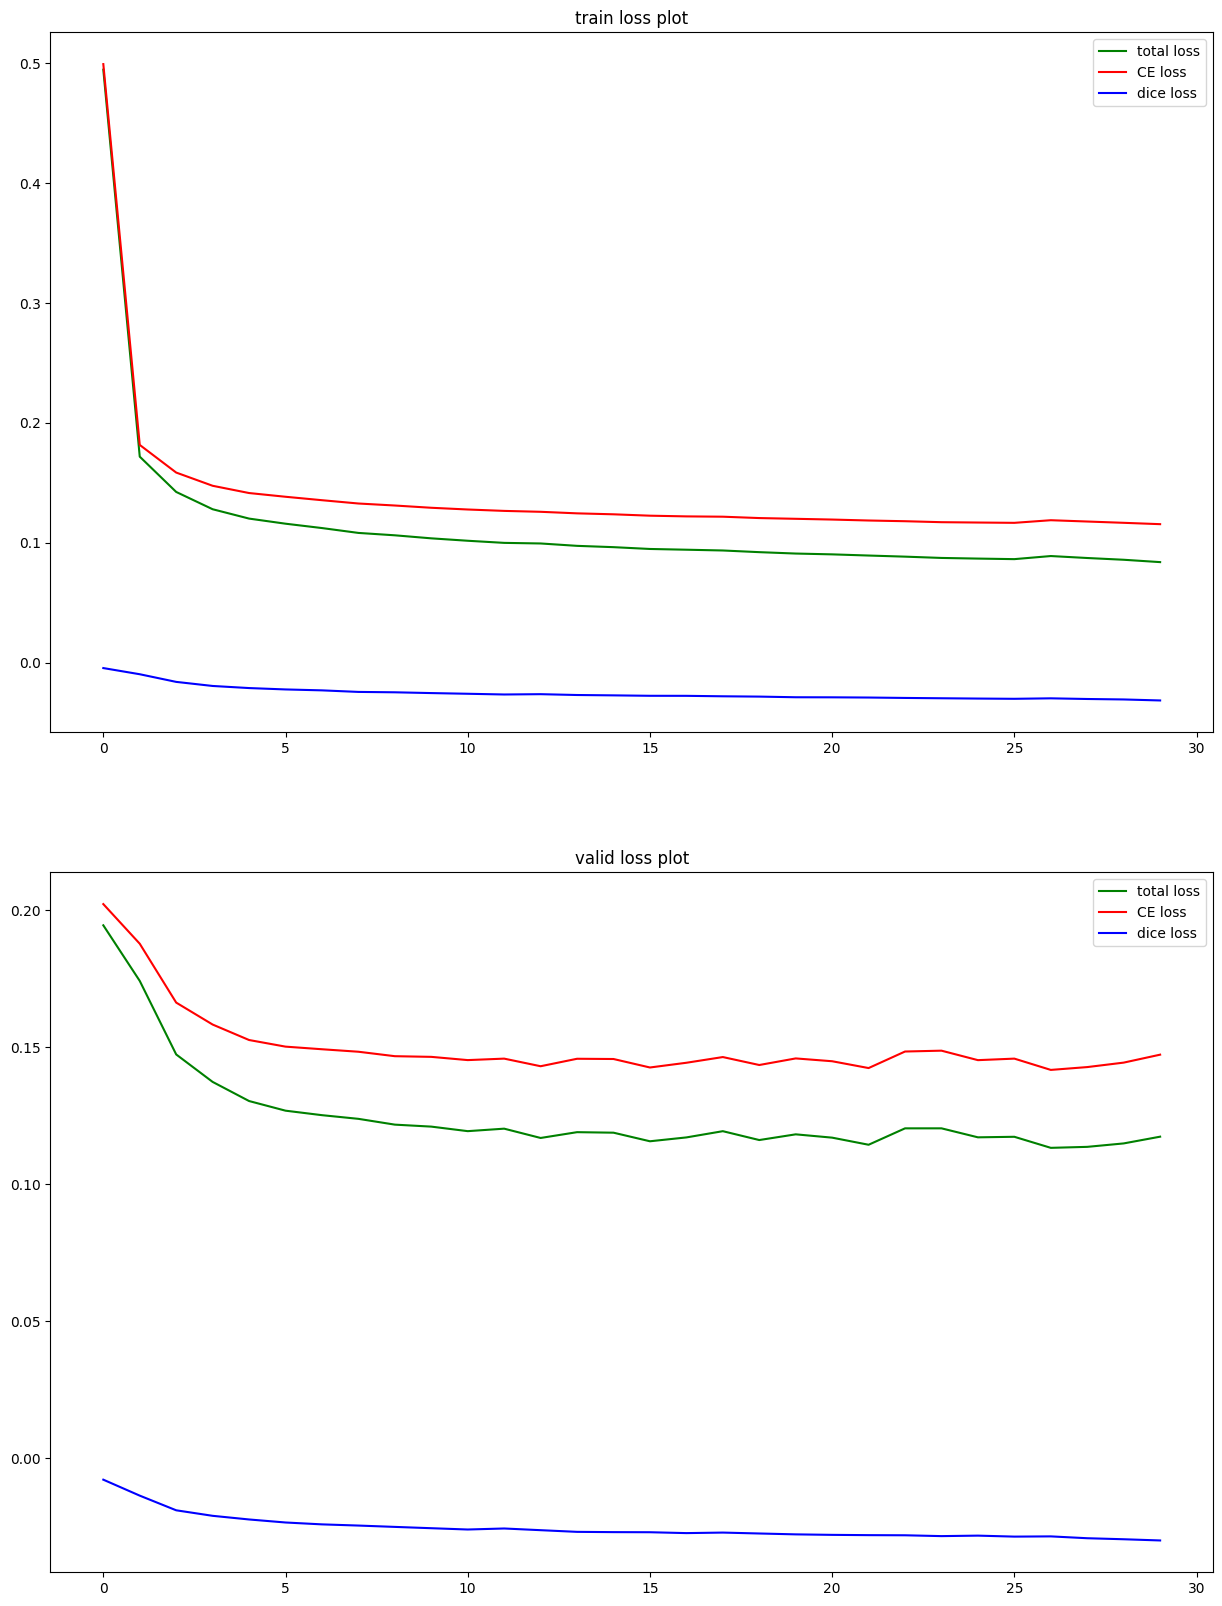

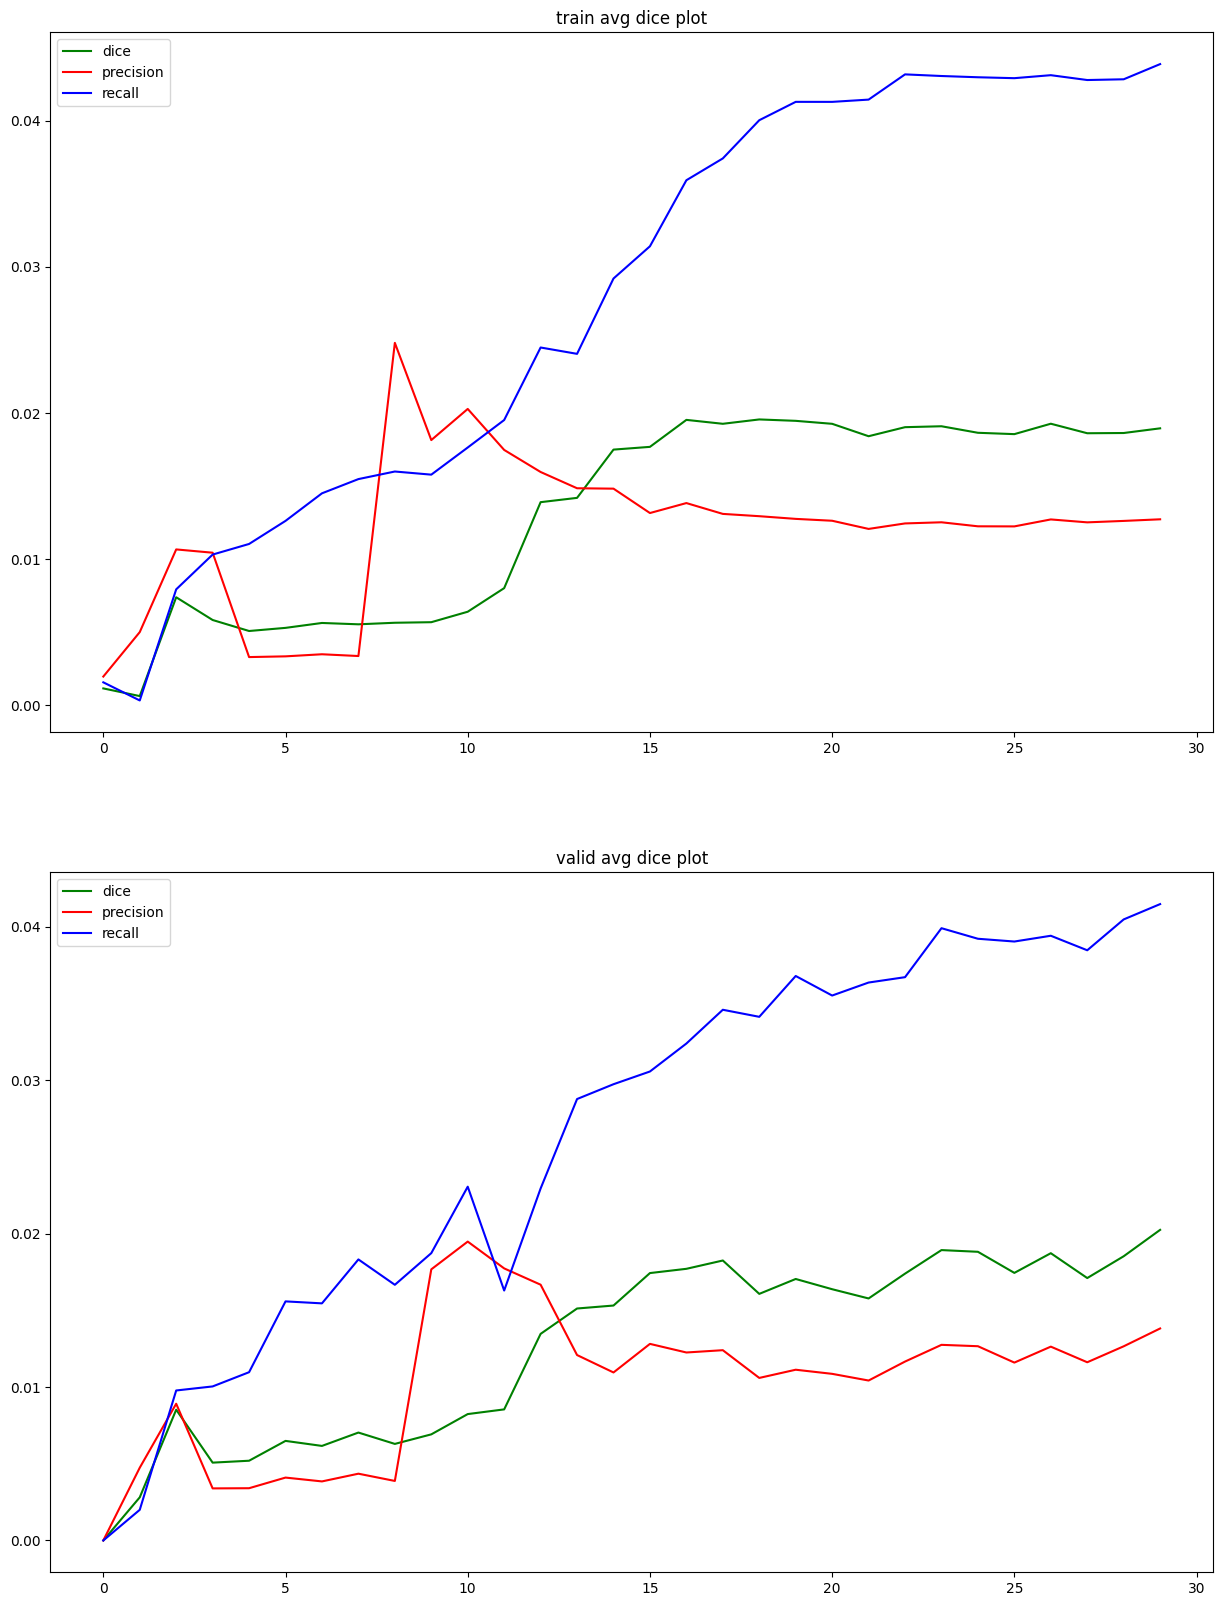

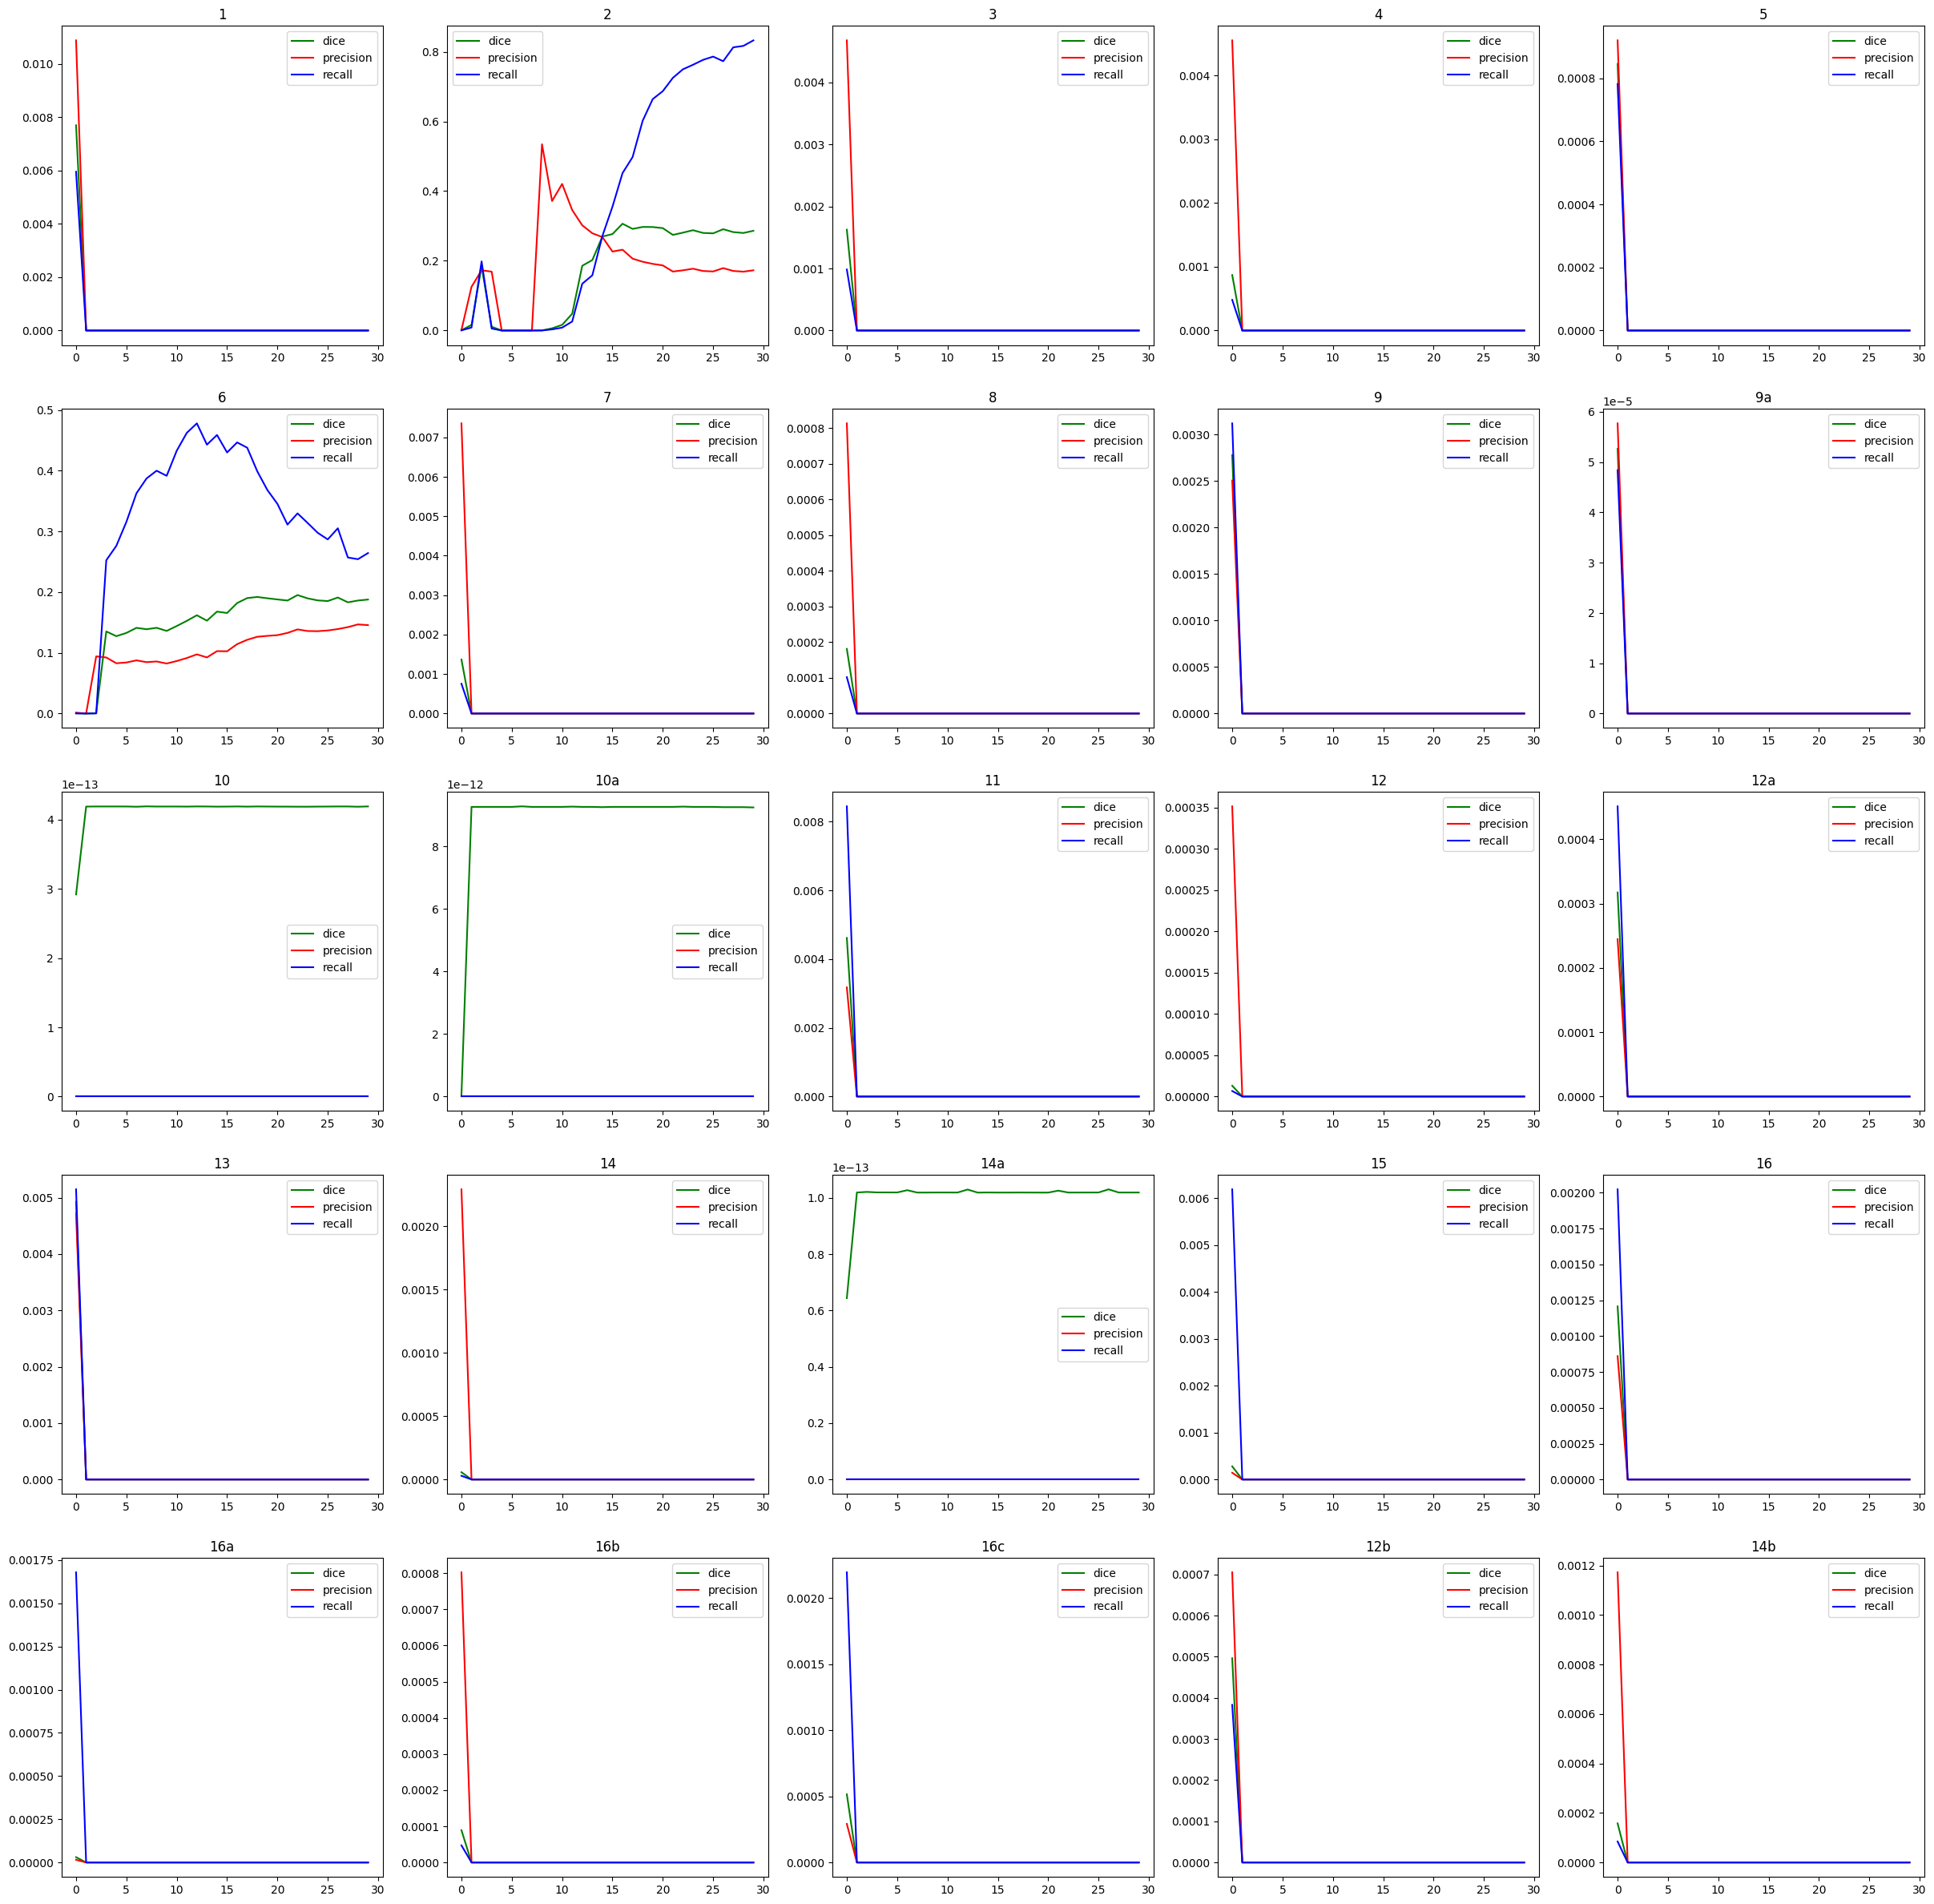

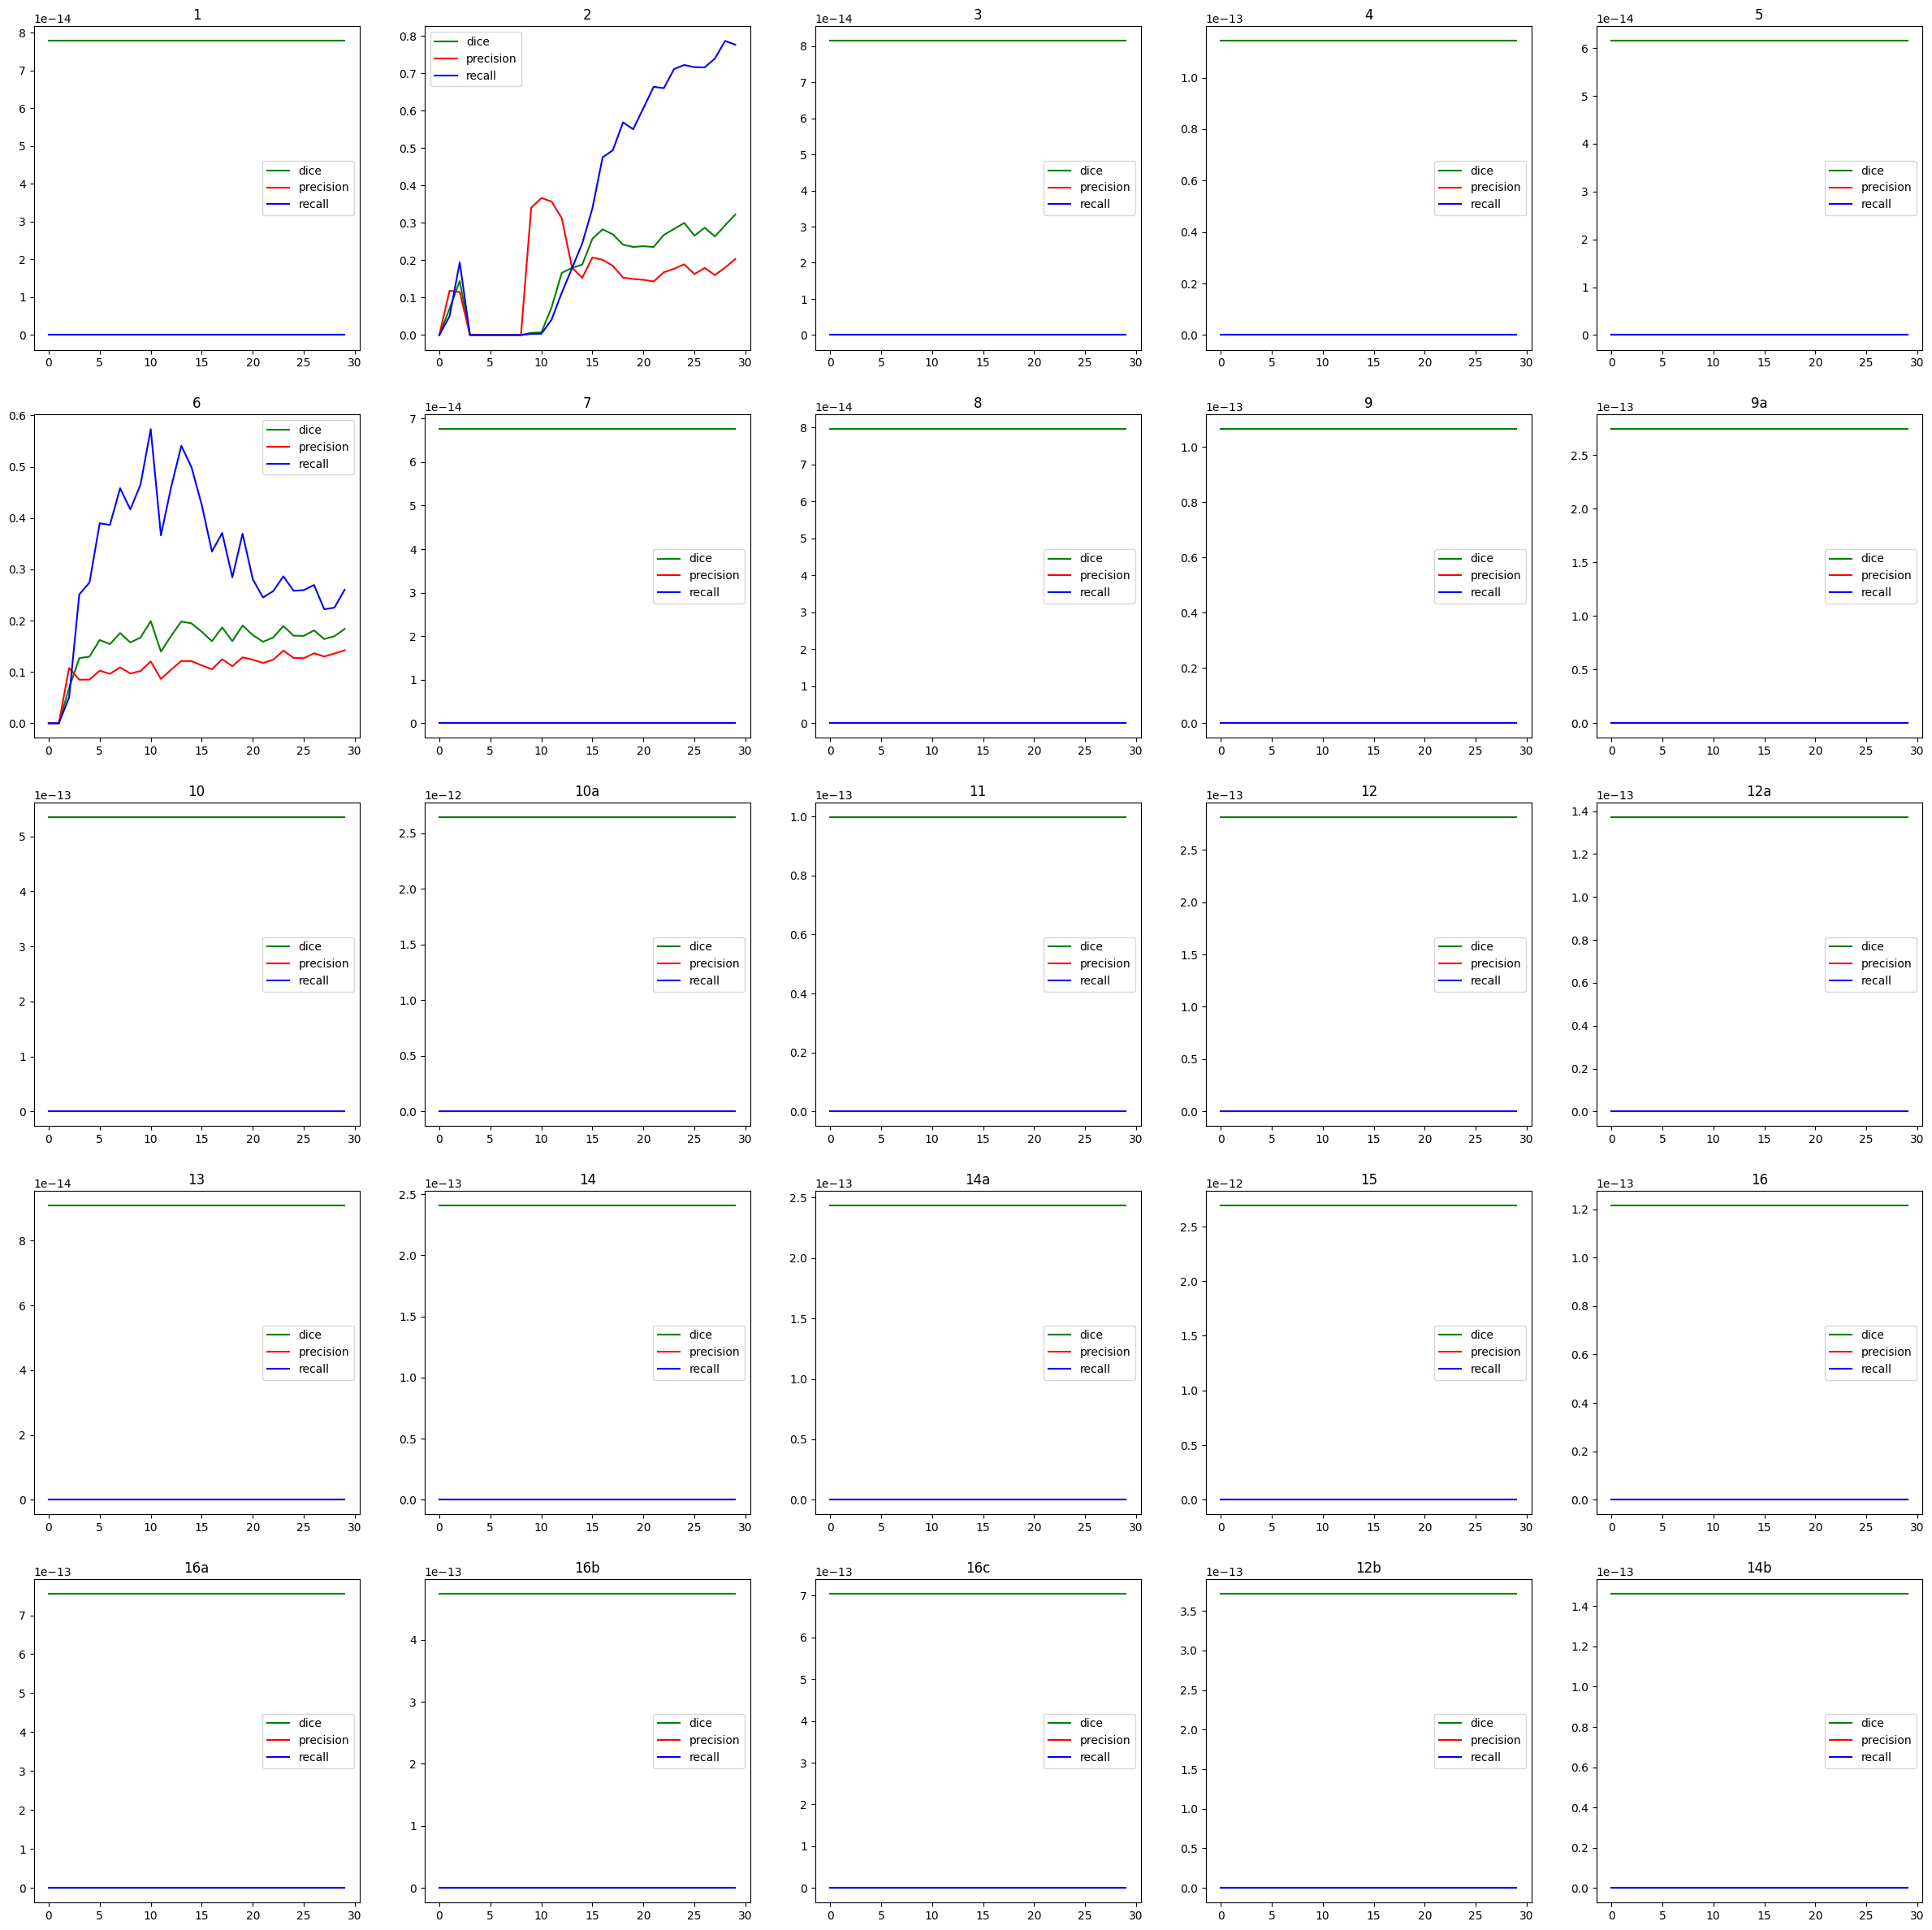

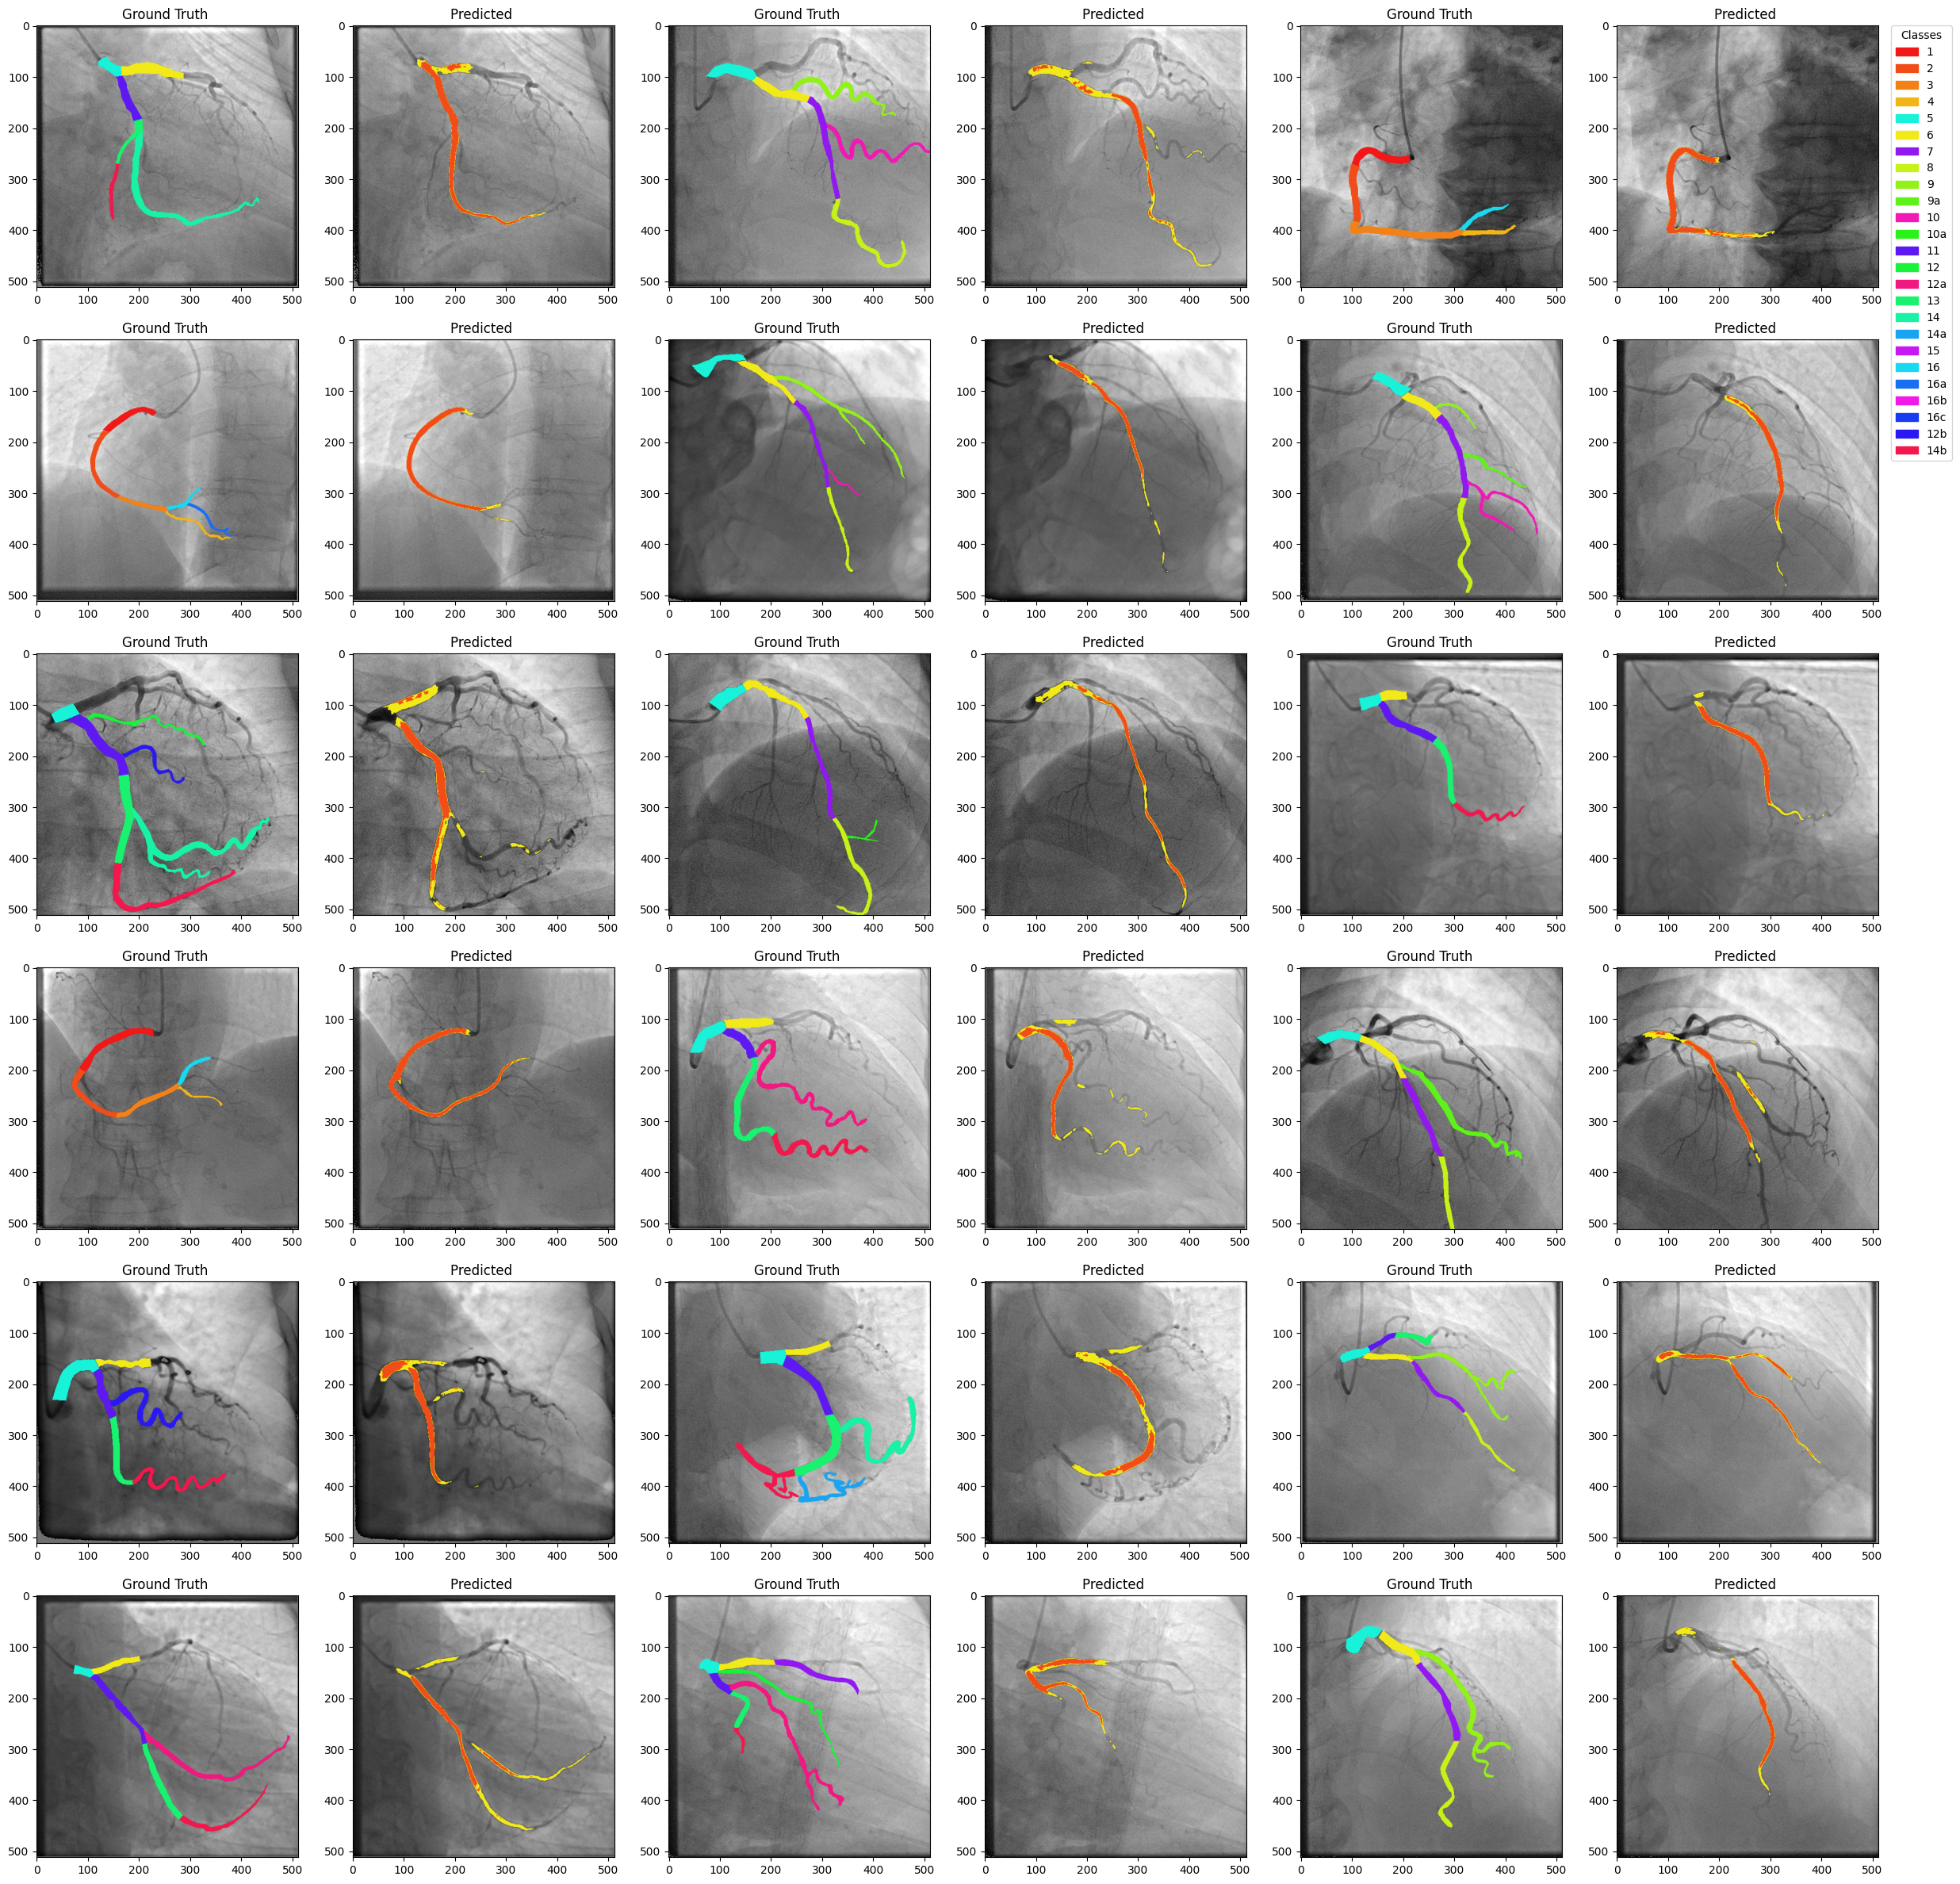

In [10]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)